STEP 1: Dataset load + basic check

In [1]:
import pandas as pd

# STEP 1: Load Kickstarter dataset
file_path = "/content/kickstarter_cleaned.csv"

df_ks = pd.read_csv(file_path)

print("Shape:", df_ks.shape)          # rows, columns
print("\nColumns:\n", df_ks.columns)  # list of columns

print("\nFirst 5 rows:")
display(df_ks.head())


Shape: (100000, 30)

Columns:
 Index(['backers_count', 'converted_pledged_amount', 'country',
       'country_displayable_name', 'created_at', 'currency', 'currency_symbol',
       'currency_trailing_code', 'current_currency', 'deadline',
       'disable_communication', 'fx_rate', 'goal',
       'is_in_post_campaign_pledging_phase', 'is_launched', 'is_starrable',
       'launched_at', 'name', 'percent_funded', 'pledged',
       'prelaunch_activated', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'usd_exchange_rate',
       'usd_pledged', 'usd_type', 'category_name'],
      dtype='object')

First 5 rows:


,backers_count,converted_pledged_amount,country,country_displayable_name,created_at,currency,currency_symbol,currency_trailing_code,current_currency,deadline,...,prelaunch_activated,spotlight,staff_pick,state,state_changed_at,static_usd_rate,usd_exchange_rate,usd_pledged,usd_type,category_name
0,70,15590.0,GB,the United Kingdom,1614367566,GBP,£,False,USD,1618513763,...,False,True,False,successful,1618513763,1.388449,1.377223,15717.245057,domestic,Dance
1,3888,700214.0,US,the United States,1694673144,USD,$,True,USD,1701439015,...,True,True,True,successful,1701439015,1.000000,1.000000,700214.000000,domestic,Gadgets
2,85,3423.0,US,the United States,1707995625,USD,$,True,USD,1729210597,...,True,True,False,successful,1729210597,1.000000,1.000000,3423.000000,domestic,Comic Books
3,103,2881.0,US,the United States,1724762600,USD,$,True,USD,1729479600,...,True,True,False,successful,1729479602,1.000000,1.000000,2881.000000,domestic,Comic Books
4,496,17071.0,US,the United States,1722535040,USD,$,True,USD,1729969439,...,True,True,False,successful,1729969439,1.000000,1.000000,17071.000000,domestic,Comic Books


STEP 2: Target column  + quick check

In [2]:
# STEP 2: Create binary target from 'state'

print("Unique states:", df_ks['state'].unique())

# Convert to binary target
df_ks['is_successful'] = (df_ks['state'] == 'successful').astype(int)

# Quick check of target distribution
print("\nTarget distribution (counts):")
print(df_ks['is_successful'].value_counts())

print("\nTarget distribution (%):")
print(df_ks['is_successful'].value_counts(normalize=True) * 100)


Unique states: ['successful' 'failed' 'canceled' 'live' 'submitted' 'started' 'suspended']

Target distribution (counts):
is_successful
1    57550
0    42450
Name: count, dtype: int64

Target distribution (%):
is_successful
1    57.55
0    42.45
Name: proportion, dtype: float64


STEP 3 — Baseline Model (Before Accuracy)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np

df = df_ks.copy()

# Remove leakage columns
leak_cols = [
    'percent_funded', 'pledged', 'usd_pledged', 'converted_pledged_amount',
    'backers_count', 'spotlight', 'is_in_post_campaign_pledging_phase',
    'currency_symbol', 'current_currency', 'static_usd_rate',
    'usd_exchange_rate'
]
df.drop(columns=leak_cols, inplace=True)

# Drop irrelevant ID/time fields
drop_more = ['name', 'state', 'created_at', 'launched_at', 'deadline', 'state_changed_at']
df.drop(columns=drop_more, inplace=True)

# Encode categoricals
cat_cols = df.select_dtypes(include=['object', 'bool']).columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Split X-y
X = df.drop('is_successful', axis=1)
y = df['is_successful']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
baseline_pred = rf.predict(X_test)

baseline_acc = accuracy_score(y_test, baseline_pred)
print("📌 Correct Baseline Accuracy:", round(baseline_acc*100,2), "%")


📌 Correct Baseline Accuracy: 79.03 %


STEP 4 — Hyperparameter Tuning

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

params_rf = {
    'n_estimators': [100,200,300,400],
    'max_depth': [5,10,20,None],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

rf_cv = RandomizedSearchCV(rf, params_rf, cv=3, scoring='accuracy',
                           n_iter=10, n_jobs=-1, verbose=1)

rf_cv.fit(X_train, y_train)

print("Best RF Accuracy:", rf_cv.best_score_)
print("Best Params:", rf_cv.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best RF Accuracy: 0.7911500010284972
Best Params: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}


STEP 5 — XGBoost Hyperparameter Tuning

In [6]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

params_xgb = {
    'n_estimators': [100,200,300,500],
    'max_depth': [3,5,7,10],
    'learning_rate': [0.01,0.05,0.1,0.2],
    'subsample': [0.7,0.8,1.0],
    'colsample_bytree': [0.7,0.8,1.0]
}

xgb_cv = RandomizedSearchCV(
    xgb,
    params_xgb,
    cv=3,
    scoring='accuracy',
    n_iter=10,
    n_jobs=-1,
    verbose=1
)

xgb_cv.fit(X_train, y_train)

print("Best XGB Accuracy:", xgb_cv.best_score_)
print("Best Params:", xgb_cv.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:16:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB Accuracy: 0.8222250143196242
Best Params: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.7}


STEP 6 — Soft Voting Ensemble

In [7]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

voting_soft = VotingClassifier(
    estimators=[
        ('rf', rf_cv.best_estimator_),
        ('xgb', xgb_cv.best_estimator_)
    ],
    voting='soft'
)

voting_soft.fit(X_train, y_train)
soft_pred = voting_soft.predict(X_test)

soft_acc = accuracy_score(y_test, soft_pred)
print("Soft Voting Accuracy:", soft_acc)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:17:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Soft Voting Accuracy: 0.81655


STEP 7️ — Hard Voting (3-Model Ensemble)

In [8]:
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.metrics import accuracy_score

ada = AdaBoostClassifier(n_estimators=200, learning_rate=0.1, random_state=42)

voting_hard = VotingClassifier(
    estimators=[
        ('rf', rf_cv.best_estimator_),
        ('xgb', xgb_cv.best_estimator_),
        ('ada', ada)
    ],
    voting='hard'
)

voting_hard.fit(X_train, y_train)
hard_pred = voting_hard.predict(X_test)

hard_acc = accuracy_score(y_test, hard_pred)
print("Hard Voting Accuracy:", hard_acc)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:19:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Hard Voting Accuracy: 0.80635


STEP 8 — Model Comparison Graph

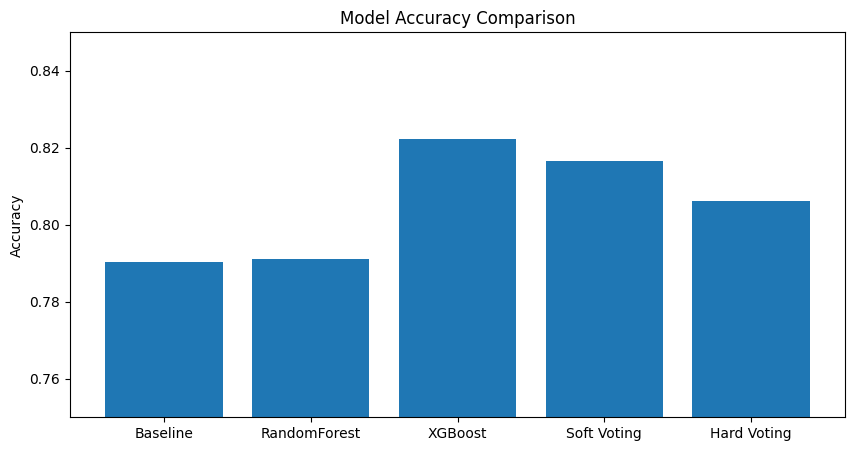

In [9]:
import matplotlib.pyplot as plt

models = ['Baseline', 'RandomForest', 'XGBoost', 'Soft Voting', 'Hard Voting']
scores = [0.7903, 0.7911, 0.8222, 0.8165, 0.8063]

plt.figure(figsize=(10,5))
plt.bar(models, scores)
plt.ylim(0.75, 0.85)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()


Step 9 – XGBoost Classification Report

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n", classification_report(y_test, xgb_cv.best_estimator_.predict(X_test)))

cm = confusion_matrix(y_test, xgb_cv.best_estimator_.predict(X_test))
print("Confusion Matrix:\n", cm)


Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79      8532
           1       0.85      0.84      0.84     11468

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000

Confusion Matrix:
 [[6849 1683]
 [1887 9581]]


Step 10 – Feature Importance Graph

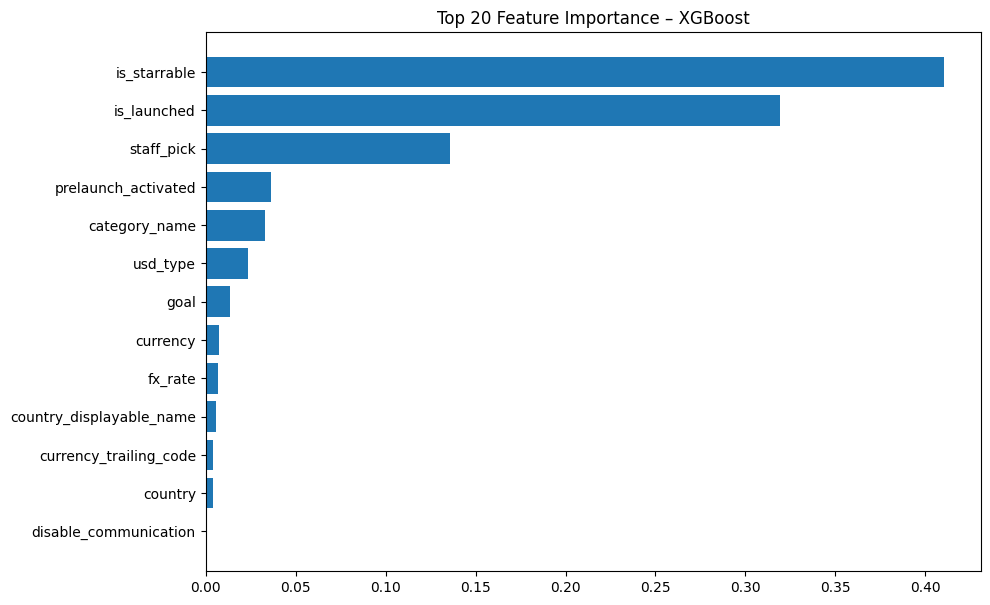

In [11]:
import numpy as np

model = xgb_cv.best_estimator_
features = X.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-20:]  # Top 20

plt.figure(figsize=(10,7))
plt.barh(features[indices], importances[indices])
plt.title("Top 20 Feature Importance – XGBoost")
plt.show()


Step 11 – Save Final Model

In [12]:
import joblib
joblib.dump(model, "Kickstarter_Final_XGB_Model.pkl")
print("Kickstarter Final Model Saved Successfully!")


Kickstarter Final Model Saved Successfully!


In [14]:
from google.colab import files
files.download("Kickstarter_Final_XGB_Model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
import json
from datetime import datetime

metadata = {
    "Model_Name": "Kickstarter_Final_XGB_Model",
    "Created_On": str(datetime.now()),
    "Accuracy": float(xgb_cv.best_score_),
    "Features_Used": list(X.columns),
    "Target": "is_successful",
    "Description": "This model predicts Kickstarter project success probability.",
    "Algorithm": "XGBoost (Hyperparameter Tuned)",
    "Dataset_Size": len(df),
    "Note": "Best performing model in comparison experiment."
}

with open("Kickstarter_Model_Metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

print("Metadata Saved Successfully!")


Metadata Saved Successfully!


In [16]:
files.download("Kickstarter_Model_Metadata.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>